<img src="pascal2.png">

# Introduction
The Pascal Visual Object Classes Challenge 2012, a.k.a. VOC2012, is a very popular dataset for building and evaluating algorithms for image classification, object detection, and segmentation. A total of 11540 images are included in this dataset, where each image contains a set of objects, out of 20 different classes, making a total of 27450 annotated objects.

The Dataset was gathered by a group of researchers:
* Mark Everingham (University of Leeds) 
* Luc Van Gool (KU Leuven, Leuven, Belgium) 
* Christopher K. I. Williams (University of Edinburgh, Edinburgh, UK)
* John Winn (Microsoft Research, Cambridge, UK)
* Andrew Zisserman (University of Oxford, Oxford, UK)

For the 2007 challenge, all images were collected from the flickr photo-sharing web-site. The use of personal photos which were not taken by, or selected by, vision/machine learning researchers results in a very “unbiased” dataset, in 
the sense that the photos are not taken with a particular purpose in mind i.e. object recognition research.
The goal of the VOC challenge is to investigate the performance of recognition methods on a wide spectrum of natural images. To this end, it is required that the VOC datasets contain significant variability in terms of object size, orientation, pose, illumination, position and occlusion. It is also important that the datasets do not exhibit systematic bias,for example, favouring images with centred objects or good illumination. It is fundamentally a supervised learning learning problem in that a training set of labelled images is provided. The twenty object classes that have been selected are:

* Person: person
* Animal: bird, cat, cow, dog, horse, sheep
* Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
* Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor





# Objective
This project will be based on the classification segement of the VOC challenge. What makes this different from the usual supervised learning problems is the multilabel component to it: the target variable can have multiple labels. The goal of this project is to use transfer learning, using a pretrained ResNet 18, and train on the VOC dataset for 15 epochs. Transfer learning is machine learning techique that enables scientist to benefit from the knowledge gained from a previously used machine learning model for a similar task. 
In addition to the machine learning technique, an additional technique will be implemented and it's effect on model performance measured: progressive resizing.
## Tools
This project is written in Python. The libraries used to tackle the project are FastAi and Pandas. FastAi is an open source library for deep learning built atop Pytorch. Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.


In [1]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.vision.data import *


In [2]:
path = untar_data('https://s3.amazonaws.com/fast-ai-imagelocal/pascal_2012.tgz')

In [3]:
Path.BASE_PATH = path
path.ls()

(#6) [Path('train'),Path('test'),Path('valid.json'),Path('segmentation'),Path('train.json'),Path('train.csv')]

In [4]:
(path/"train").ls()

(#11540) [Path('train/2010_001140.jpg'),Path('train/2008_004907.jpg'),Path('train/2010_005998.jpg'),Path('train/2011_003275.jpg'),Path('train/2008_000090.jpg'),Path('train/2009_002311.jpg'),Path('train/2010_000395.jpg'),Path('train/2009_001201.jpg'),Path('train/2009_002325.jpg'),Path('train/2008_006355.jpg')...]

In [5]:
import pandas as pd

In [6]:
label = pd.read_csv(path/"train.csv")

In [7]:
label.head()

,fname,labels,is_valid
0,2008_000002.jpg,tvmonitor,True
1,2008_000003.jpg,train person,True
2,2008_000007.jpg,boat,True
3,2008_000008.jpg,horse person,False
4,2008_000009.jpg,cow,True


In [8]:
label['labels'].value_counts()

person                                         1002
cat                                             818
dog                                             784
bird                                            698
aeroplane                                       553
                                               ... 
chair diningtable tvmonitor person                1
pottedplant person diningtable chair              1
bottle sofa diningtable person chair              1
bottle chair diningtable person pottedplant       1
person sofa diningtable chair                     1
Name: labels, Length: 761, dtype: int64

In [9]:
len(label["labels"].unique())

761

In [10]:
label["labels"].value_counts(normalize=True)

person                                         0.086828
cat                                            0.070884
dog                                            0.067938
bird                                           0.060485
aeroplane                                      0.047920
                                                 ...   
chair diningtable tvmonitor person             0.000087
pottedplant person diningtable chair           0.000087
bottle sofa diningtable person chair           0.000087
bottle chair diningtable person pottedplant    0.000087
person sofa diningtable chair                  0.000087
Name: labels, Length: 761, dtype: float64

In [11]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid


In [12]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')


In [13]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)

dsets = dblock.datasets(label)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [15]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=[ImageBlock, MultiCategoryBlock],
                  get_x=get_x,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=[Resize(460)],
                  batch_tfms = [*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(label, bs=bs)




# Base Model

### Resnet-18

The base model is a Resnet-18 model. Resnet is a state-of-the-art artificial neural network. The distinct feature of a Resnet is the method by which the it deals with Vanishing gradients: skipping over layers the by reusing activations from a previous layer until the adjacent layer learns its weights. During training, the weights adapt to mute the upstream layer[clarification needed], and amplify the previously-skipped layer.

For the base model, the Resnet model is trained with a presize technique and the learning rate optimized later on.
Presizing is a technique that resize images to large dimensions, larger than the training image and compose all of the common augmentation operations into one and perform the operation on the GPU only once at the end of the processing.

In [16]:
dls = get_dls(64, 224)

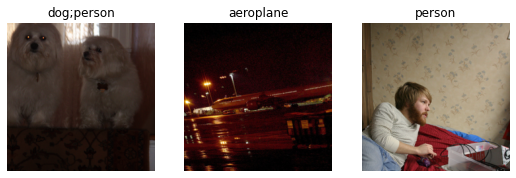

In [17]:
dls.show_batch(nrows=1, ncols=3)

In [18]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(18)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.748415,0.350294,0.465490,00:41


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.370339,0.236810,0.692839,00:31
1,0.261940,0.142270,0.911369,00:31
2,0.171109,0.100369,0.952301,00:31
3,0.127934,0.088575,0.958037,00:32
4,0.105623,0.085152,0.959351,00:31
5,0.094109,0.084286,0.959823,00:32
6,0.084603,0.082598,0.962219,00:32
7,0.075162,0.084118,0.962614,00:31
8,0.068147,0.085417,0.961781,00:31
9,0.061556,0.087434,0.959110,00:31


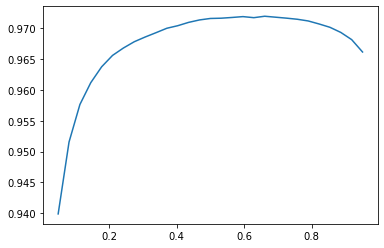

In [19]:
preds,targs = learn.get_preds()
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [20]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.6))
learn.fine_tune(18)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.749702,0.351496,0.934767,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.379854,0.228179,0.962219,00:31
1,0.264284,0.139097,0.967568,00:31
2,0.173481,0.099739,0.967465,00:31
3,0.129664,0.088962,0.968684,00:31
4,0.109177,0.085438,0.969646,00:31
5,0.095683,0.085019,0.969681,00:31
6,0.086075,0.084618,0.970522,00:31
7,0.077333,0.084181,0.970994,00:31
8,0.069678,0.085319,0.970951,00:32
9,0.061480,0.085553,0.971235,00:32


# Progressive Resizing

Progressive Resizing is a training technique (it's also a Data augmentation technique) where at the start of the training the model is given small images and towards the end of the training the model is given larger images (there is no benefit making the image bigger than what is on the Disk).

It’s faster to train on larger numbers of smaller images initially and then scale up the network and training images. Progressive resizing also helps the model to generalise better as is sees many more different images and less likely to be overfitting. In addition, as the training image size increases the batch size has to decreased to avoid running out of memory, as each batch contains larger images with more pixels in each.


In [21]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=[ImageBlock, MultiCategoryBlock],
                  get_x=get_x,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=[Resize(460)],
                  batch_tfms = [*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(label, bs=bs)




In [22]:
dls = get_dls(128, 128)
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.6))
learn.fit_one_cycle(10, 3e-3)
learn.dls = get_dls(64, 224)
learn.fine_tune(8)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944729,0.673117,0.754903,00:31
1,0.698588,0.255805,0.952129,00:30
2,0.376663,0.121327,0.957427,00:29
3,0.232982,0.113350,0.959239,00:29
4,0.170792,0.108525,0.960768,00:29
5,0.140930,0.105896,0.961729,00:30
6,0.125067,0.104056,0.962923,00:30
7,0.116230,0.103179,0.962734,00:30
8,0.111800,0.102387,0.963155,00:30
9,0.110199,0.102263,0.963198,00:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.102741,0.086377,0.968668,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.094338,0.082334,0.969844,00:31
1,0.091161,0.083437,0.969826,00:32
2,0.085888,0.082661,0.970608,00:31
3,0.078437,0.081503,0.971218,00:32
4,0.069961,0.081741,0.971260,00:31
5,0.061251,0.080230,0.972626,00:31
6,0.056095,0.080224,0.972222,00:31
7,0.052878,0.080143,0.972506,00:31


## Results

As observed from the results above, the progressive resizing model performed better than the base resnet-18 model. Focusing on the Training and Valid Loss, the base model is overfitting as the training loss is significantly lower than the validation loss. 


| Technique              | Accuracy     | Train Loss   | Valid Loss   |
| :----------------------| :----------: | -----------: | -----------: |
| Base Model             | 97.1398      | 0.034572     | 0.091455     |
| Progressive Resizing   | 97.2506      | 0.052878     | 0.080143     |

### Suggestions for Improvement
* More Image augmentations like horizontal flip etc.
* Remove images in the datasets that are improperly labelled.
* Training with different progressive sizes.